In [1]:
import sys
import pprint
import pylab as pl
sys.path.insert(0, '..')

import pymola.parser
import pymola.gen_sympy
import sympy
sympy.init_printing()
%load_ext autoreload

%autoreload 2
%matplotlib inline

# Modelica Source Code

In [2]:
modelica_src = '''

model Spring
    Real x, v_x;
    parameter Real c = 0.1;
    parameter Real k = 2;
equation
    der(x) = v_x;
    der(v_x) = -k*x - c*v_x;
end Spring;

'''

# Generation of Abstract Syntax Tree

In [3]:
ast = pymola.parser.parse(modelica_src)
print(ast)

{
  "classes": {
    "Spring": {
      "comment": "",
      "constants": [],
      "encapsulated": false,
      "equations": [
        {
          "comment": "",
          "left": {
            "operands": [
              {
                "name": "x"
              }
            ],
            "operator": "der"
          },
          "right": {
            "name": "v_x"
          }
        },
        {
          "comment": "",
          "left": {
            "operands": [
              {
                "name": "v_x"
              }
            ],
            "operator": "der"
          },
          "right": {
            "operands": [
              {
                "operands": [
                  {
                    "operands": [
                      {
                        "name": "k"
                      }
                    ],
                    "operator": "-"
                  },
                  {
                    "name": "x"
                  }
                ],
 

# Generation of Sympy Model

In [4]:
ball_sympy = pymola.gen_sympy.generate(ast, 'Spring')
#print(ball_sympy)

In [5]:
exec(ball_sympy)
model = Spring()
model

{'c': Matrix(0, 0, []), 't': t, 'f': Matrix([
[            v_x(t)],
[-c*v_x(t) - k*x(t)]]), 'v': Matrix(0, 0, []), 'p': Matrix([
[c],
[k]]), 'y': Matrix(0, 0, []), 'p0': {'c': 0.1, 'k': 2}, 'c0': {}, 'u': Matrix(0, 0, []), 'eqs': [-v_x(t) + Derivative(x(t), t), c*v_x(t) + k*x(t) + Derivative(v_x(t), t)], 'x': Matrix([
[  x(t)],
[v_x(t)]]), 'g': Matrix(0, 0, [])}

In [6]:
model.linearize()

⎛⎡0   1 ⎤, [], [], []⎞
⎜⎢      ⎥            ⎟
⎝⎣-k  -c⎦            ⎠

# Simulation of Sympy Model

In [7]:
res = model.simulate(x0 =[1, 1], t0=10, tf=20, dt=0.001)

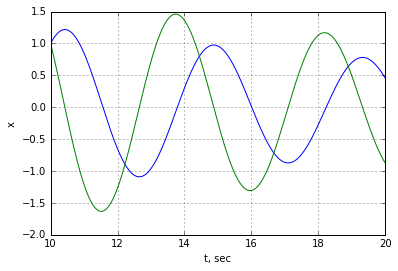

In [8]:
pl.plot(res['t'], res['x'])
pl.grid()
pl.xlabel('t, sec')
pl.ylabel('x')

In [9]:
sympy.init_printing()
model.f

⎡      vₓ(t)      ⎤
⎢                 ⎥
⎣-c⋅vₓ(t) - k⋅x(t)⎦

In [10]:
model.f.jacobian(model.x)

⎡0   1 ⎤
⎢      ⎥
⎣-k  -c⎦

In [11]:
model.f.jacobian(model.p)

⎡  0       0  ⎤
⎢             ⎥
⎣-vₓ(t)  -x(t)⎦

# Lyapunov Stability

Using the energy function as a candidate function, we can show that the system has global exponential stability (GES).

In [12]:
v_x, k, t, V, x = sympy.symbols('v_x, k, t, V, x')
V_eq = (v_x(t)**2 + k*x(t)**2)/2
sympy.Eq(V, V_eq)

       2        2   
    k⋅x (t)   vₓ (t)
V = ─────── + ──────
       2        2   

In [13]:
dV_dt_eq = (sympy.Matrix([V_eq]).jacobian(model.x).dot(model.f)).simplify()
sympy.Eq(V(t).diff(t), dV_dt_eq)

d               2   
──(V(t)) = -c⋅vₓ (t)
dt                  

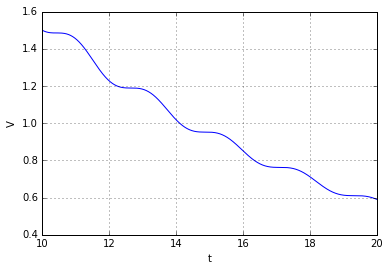

In [14]:
V_lam = sympy.lambdify(model.x, V_eq.subs(model.p0))
V_vals = [V_lam(*x) for x in res['x']]
pl.plot(res['t'], V_vals)
pl.xlabel('t')
pl.ylabel('V')
pl.grid()

# Parameter Sensitivity

In [17]:
model.f.jacobian(model.p)

⎡  0       0  ⎤
⎢             ⎥
⎣-vₓ(t)  -x(t)⎦